# Simulating long experiments

This notebook introduces functionality for simulating experiments over hundreds or even thousands of cycles. 

In [1]:
%pip install pybamm -q
import pybamm
import matplotlib.pyplot as plt
import numpy as np

You should consider upgrading via the '/Users/vsulzer/Documents/Energy_storage/PyBaMM/.tox/dev/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Simulating long experiments

In the interest of simplicity and running time, we consider a SPM with SEI effects leading to linear degradation, with parameter values chosen so that the capacity fades by 20% in just a few cycles

In [2]:
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
parameter_values.update({"SEI kinetic rate constant [m.s-1]": 1e-14})
spm = pybamm.lithium_ion.SPM({"SEI": "ec reaction limited"})

Using the "Electrode SOH" (eSOH) model, we initialize the concentration in each electrode at 100% State of Charge

In [3]:
# Calculate stoichiometries at 100% SOC
esoh_model = pybamm.lithium_ion.ElectrodeSOH()
esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
param = spm.param

Vmin = 3.0
Vmax = 4.2
Cn = parameter_values.evaluate(param.C_n_init)
Cp = parameter_values.evaluate(param.C_p_init)
n_Li_init = parameter_values.evaluate(param.n_Li_particles_init)

esoh_sol = esoh_sim.solve(
    [0],
    inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
)
print(f"Initial negative electrode SOC: {esoh_sol['x_100'].data[0]:.3f}")
print(f"Initial positive electrode SOC: {esoh_sol['y_100'].data[0]:.3f}")

# Update parameter values with initial conditions
c_n_max = parameter_values.evaluate(param.c_n_max)
c_p_max = parameter_values.evaluate(param.c_p_max)
parameter_values.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": esoh_sol["x_100"].data[0] * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": esoh_sol["y_100"].data[0] * c_p_max,
    }
)

Initial negative electrode SOC: 0.833
Initial positive electrode SOC: 0.034


We can now simulate a single CCCV cycle using the `Experiment` class (see [this notebook](https://github.com/pybamm-team/PyBaMM/blob/develop/examples/notebooks/Getting%20Started/Tutorial%205%20-%20Run%20experiments.ipynb) for more details)

In [4]:
pybamm.set_logging_level("NOTICE")

experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50"
    )
])
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol = sim.solve()

2021-05-24 09:03:27,605 - [NOTICE] simulation.solve(710): Cycle 1/1 (152.113 ms elapsed) --------------------
2021-05-24 09:03:27,606 - [NOTICE] simulation.solve(742): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-05-24 09:03:27,778 - [NOTICE] simulation.solve(742): Cycle 1/1, step 2/4: Rest for 1 hour
2021-05-24 09:03:27,923 - [NOTICE] simulation.solve(742): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-05-24 09:03:28,101 - [NOTICE] simulation.solve(742): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-05-24 09:03:28,606 - [NOTICE] simulation.solve(837): Finish experiment simulation, took 1.153 s


Alternatively, we can simulate many CCCV cycles. Here we simulate either 100 cycles or until the capacity is 80% of the initial capacity, whichever is first. The capacity is calculated by the eSOH model

In [5]:
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
    f"Charge at 1C until {Vmax}V", 
    f"Hold at {Vmax}V until C/50")
] * 500,
termination="80% capacity"
)
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol = sim.solve()

2021-05-24 09:03:31,209 - [NOTICE] simulation.solve(710): Cycle 1/500 (53.770 ms elapsed) --------------------
2021-05-24 09:03:31,210 - [NOTICE] simulation.solve(742): Cycle 1/500, step 1/4: Discharge at 1C until 3.0V
2021-05-24 09:03:31,400 - [NOTICE] simulation.solve(742): Cycle 1/500, step 2/4: Rest for 1 hour
2021-05-24 09:03:31,571 - [NOTICE] simulation.solve(742): Cycle 1/500, step 3/4: Charge at 1C until 4.2V
2021-05-24 09:03:31,757 - [NOTICE] simulation.solve(742): Cycle 1/500, step 4/4: Hold at 4.2V until C/50
2021-05-24 09:03:32,406 - [NOTICE] simulation.solve(820): Capacity is now 4.941 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2021-05-24 09:03:32,407 - [NOTICE] simulation.solve(710): Cycle 2/500 (1.252 s elapsed) --------------------
2021-05-24 09:03:32,408 - [NOTICE] simulation.solve(742): Cycle 2/500, step 1/4: Discharge at 1C until 3.0V
2021-05-24 09:03:32,538 - [NOTICE] simulation.solve(742): Cycle 2/500, step 2/4: Rest for 1 hour
2021-05-24 09:03:32,629 - [NOTIC

2021-05-24 09:03:38,042 - [NOTICE] simulation.solve(742): Cycle 13/500, step 4/4: Hold at 4.2V until C/50
2021-05-24 09:03:38,175 - [NOTICE] simulation.solve(820): Capacity is now 4.637 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2021-05-24 09:03:38,176 - [NOTICE] simulation.solve(710): Cycle 14/500 (7.020 s elapsed) --------------------
2021-05-24 09:03:38,176 - [NOTICE] simulation.solve(742): Cycle 14/500, step 1/4: Discharge at 1C until 3.0V
2021-05-24 09:03:38,295 - [NOTICE] simulation.solve(742): Cycle 14/500, step 2/4: Rest for 1 hour
2021-05-24 09:03:38,383 - [NOTICE] simulation.solve(742): Cycle 14/500, step 3/4: Charge at 1C until 4.2V
2021-05-24 09:03:38,495 - [NOTICE] simulation.solve(742): Cycle 14/500, step 4/4: Hold at 4.2V until C/50
2021-05-24 09:03:38,635 - [NOTICE] simulation.solve(820): Capacity is now 4.614 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2021-05-24 09:03:38,636 - [NOTICE] simulation.solve(710): Cycle 15/500 (7.481 s elapsed) --------------------

2021-05-24 09:03:43,753 - [NOTICE] simulation.solve(742): Cycle 26/500, step 1/4: Discharge at 1C until 3.0V
2021-05-24 09:03:43,859 - [NOTICE] simulation.solve(742): Cycle 26/500, step 2/4: Rest for 1 hour
2021-05-24 09:03:43,945 - [NOTICE] simulation.solve(742): Cycle 26/500, step 3/4: Charge at 1C until 4.2V
2021-05-24 09:03:44,044 - [NOTICE] simulation.solve(742): Cycle 26/500, step 4/4: Hold at 4.2V until C/50
2021-05-24 09:03:44,182 - [NOTICE] simulation.solve(820): Capacity is now 4.362 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2021-05-24 09:03:44,183 - [NOTICE] simulation.solve(710): Cycle 27/500 (13.028 s elapsed) --------------------
2021-05-24 09:03:44,183 - [NOTICE] simulation.solve(742): Cycle 27/500, step 1/4: Discharge at 1C until 3.0V
2021-05-24 09:03:44,284 - [NOTICE] simulation.solve(742): Cycle 27/500, step 2/4: Rest for 1 hour
2021-05-24 09:03:44,377 - [NOTICE] simulation.solve(742): Cycle 27/500, step 3/4: Charge at 1C until 4.2V
2021-05-24 09:03:44,476 - [NO

2021-05-24 09:03:49,619 - [NOTICE] simulation.solve(742): Cycle 38/500, step 4/4: Hold at 4.2V until C/50
2021-05-24 09:03:49,754 - [NOTICE] simulation.solve(820): Capacity is now 4.143 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2021-05-24 09:03:49,754 - [NOTICE] simulation.solve(710): Cycle 39/500 (18.599 s elapsed) --------------------
2021-05-24 09:03:49,755 - [NOTICE] simulation.solve(742): Cycle 39/500, step 1/4: Discharge at 1C until 3.0V
2021-05-24 09:03:49,867 - [NOTICE] simulation.solve(742): Cycle 39/500, step 2/4: Rest for 1 hour
2021-05-24 09:03:49,964 - [NOTICE] simulation.solve(742): Cycle 39/500, step 3/4: Charge at 1C until 4.2V
2021-05-24 09:03:50,060 - [NOTICE] simulation.solve(742): Cycle 39/500, step 4/4: Hold at 4.2V until C/50
2021-05-24 09:03:50,200 - [NOTICE] simulation.solve(820): Capacity is now 4.126 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2021-05-24 09:03:50,200 - [NOTICE] simulation.solve(710): Cycle 40/500 (19.045 s elapsed) ------------------

### Summary variables

We can plot standard variables like the current and voltage, but it isn't very instructive on these timescales

In [6]:
sol.plot(["Current [A]", "Terminal voltage [V]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=147.04264089559257, step=1.4704264089559258)…

Instead, we plot "summary variables", which show how the battery degrades over time by various metrics. Some of the variables also have "Change in ...", which is how much that variable changes over each cycle.

In [7]:
sorted(sol.summary_variables.keys())

['C',
 'C_n',
 'C_n * (x_100 - x_0)',
 'C_p',
 'C_p * (y_100 - y_0)',
 'Capacity [A.h]',
 'Change in local ECM resistance [Ohm]',
 'Change in loss of active material in negative electrode [%]',
 'Change in loss of active material in positive electrode [%]',
 'Change in loss of capacity to negative electrode SEI [A.h]',
 'Change in loss of capacity to negative electrode lithium plating [A.h]',
 'Change in loss of capacity to positive electrode SEI [A.h]',
 'Change in loss of capacity to positive electrode lithium plating [A.h]',
 'Change in loss of lithium inventory [%]',
 'Change in loss of lithium inventory, including electrolyte [%]',
 'Change in loss of lithium to negative electrode SEI [mol]',
 'Change in loss of lithium to negative electrode lithium plating [mol]',
 'Change in loss of lithium to positive electrode SEI [mol]',
 'Change in loss of lithium to positive electrode lithium plating [mol]',
 'Change in negative electrode capacity [A.h]',
 'Change in positive electrode capa

Here the only degradation mechanism is one that causes loss of lithium, so we don't see loss of active material

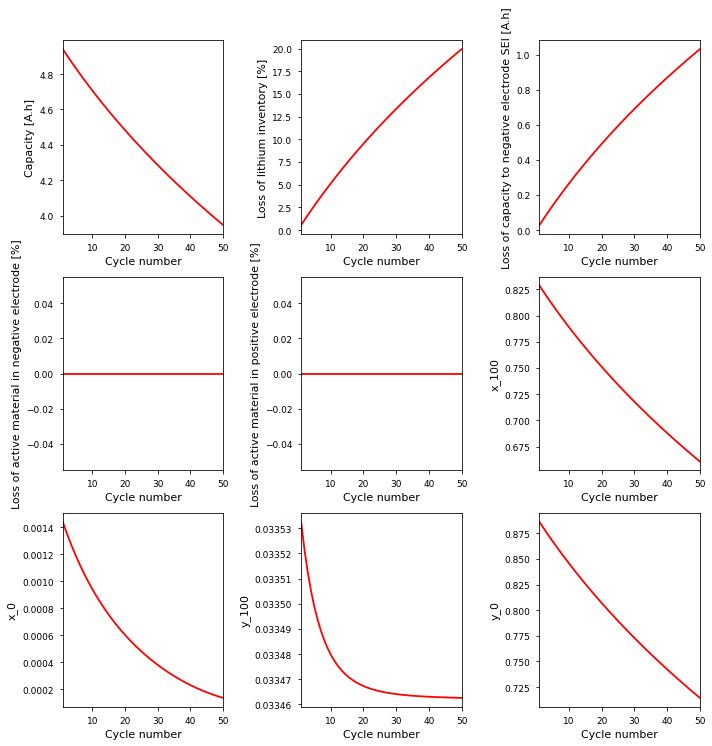

In [8]:
vars_to_plot = [
    "Capacity [A.h]",
    "Loss of lithium inventory [%]",
    "Loss of capacity to negative electrode SEI [A.h]",
    "Loss of active material in negative electrode [%]",
    "Loss of active material in positive electrode [%]",
    "x_100",
    "x_0",
    "y_100",
    "y_0"
]
l = len(vars_to_plot)
n = int(l//np.sqrt(l))
m = int(np.ceil(l/n))

fig, axes = plt.subplots(n,m,figsize=(10,10))
for var, ax in zip(vars_to_plot,axes.flat):
    ax.plot(sol.summary_variables["Cycle number"], sol.summary_variables[var])
    ax.set_xlabel("Cycle number")
    ax.set_ylabel(var)
    ax.set_xlim([1,sol.summary_variables["Cycle number"][-1]])
fig.tight_layout()

To suggest additional summary variables, open an issue!

## Choosing which cycles to save

If the simulation contains thousands of cycles, saving each cycle in RAM might not be possible. To get around this, we can use `save_at_cycles`. If this is an integer `n`, every nth cycle is saved. If this is a list, all the cycles in the list are saved.
The first cycle is always saved.

In [9]:
# With integer
sol_int = sim.solve(save_at_cycles=5)
# With list
sol_list = sim.solve(save_at_cycles=[30,45,55])

2021-05-24 09:03:59,225 - [NOTICE] simulation.solve(710): Cycle 1/500 (62.655 ms elapsed) --------------------
2021-05-24 09:03:59,226 - [NOTICE] simulation.solve(742): Cycle 1/500, step 1/4: Discharge at 1C until 3.0V
2021-05-24 09:03:59,368 - [NOTICE] simulation.solve(742): Cycle 1/500, step 2/4: Rest for 1 hour
2021-05-24 09:03:59,485 - [NOTICE] simulation.solve(742): Cycle 1/500, step 3/4: Charge at 1C until 4.2V
2021-05-24 09:03:59,610 - [NOTICE] simulation.solve(742): Cycle 1/500, step 4/4: Hold at 4.2V until C/50
2021-05-24 09:03:59,975 - [NOTICE] simulation.solve(820): Capacity is now 4.941 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2021-05-24 09:03:59,976 - [NOTICE] simulation.solve(710): Cycle 2/500 (813.963 ms elapsed) --------------------
2021-05-24 09:03:59,977 - [NOTICE] simulation.solve(742): Cycle 2/500, step 1/4: Discharge at 1C until 3.0V
2021-05-24 09:04:00,118 - [NOTICE] simulation.solve(742): Cycle 2/500, step 2/4: Rest for 1 hour
2021-05-24 09:04:00,210 - [NO

2021-05-24 09:04:05,780 - [NOTICE] simulation.solve(742): Cycle 13/500, step 4/4: Hold at 4.2V until C/50
2021-05-24 09:04:05,916 - [NOTICE] simulation.solve(820): Capacity is now 4.637 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2021-05-24 09:04:05,917 - [NOTICE] simulation.solve(710): Cycle 14/500 (6.755 s elapsed) --------------------
2021-05-24 09:04:05,918 - [NOTICE] simulation.solve(742): Cycle 14/500, step 1/4: Discharge at 1C until 3.0V
2021-05-24 09:04:06,034 - [NOTICE] simulation.solve(742): Cycle 14/500, step 2/4: Rest for 1 hour
2021-05-24 09:04:06,133 - [NOTICE] simulation.solve(742): Cycle 14/500, step 3/4: Charge at 1C until 4.2V
2021-05-24 09:04:06,245 - [NOTICE] simulation.solve(742): Cycle 14/500, step 4/4: Hold at 4.2V until C/50
2021-05-24 09:04:06,386 - [NOTICE] simulation.solve(820): Capacity is now 4.614 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2021-05-24 09:04:06,387 - [NOTICE] simulation.solve(710): Cycle 15/500 (7.225 s elapsed) --------------------

2021-05-24 09:04:11,653 - [NOTICE] simulation.solve(742): Cycle 26/500, step 1/4: Discharge at 1C until 3.0V
2021-05-24 09:04:11,760 - [NOTICE] simulation.solve(742): Cycle 26/500, step 2/4: Rest for 1 hour
2021-05-24 09:04:11,855 - [NOTICE] simulation.solve(742): Cycle 26/500, step 3/4: Charge at 1C until 4.2V
2021-05-24 09:04:11,959 - [NOTICE] simulation.solve(742): Cycle 26/500, step 4/4: Hold at 4.2V until C/50
2021-05-24 09:04:12,100 - [NOTICE] simulation.solve(820): Capacity is now 4.362 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2021-05-24 09:04:12,101 - [NOTICE] simulation.solve(710): Cycle 27/500 (12.939 s elapsed) --------------------
2021-05-24 09:04:12,102 - [NOTICE] simulation.solve(742): Cycle 27/500, step 1/4: Discharge at 1C until 3.0V
2021-05-24 09:04:12,209 - [NOTICE] simulation.solve(742): Cycle 27/500, step 2/4: Rest for 1 hour
2021-05-24 09:04:12,304 - [NOTICE] simulation.solve(742): Cycle 27/500, step 3/4: Charge at 1C until 4.2V
2021-05-24 09:04:12,407 - [NO

2021-05-24 09:04:17,619 - [NOTICE] simulation.solve(742): Cycle 38/500, step 4/4: Hold at 4.2V until C/50
2021-05-24 09:04:17,754 - [NOTICE] simulation.solve(820): Capacity is now 4.143 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2021-05-24 09:04:17,755 - [NOTICE] simulation.solve(710): Cycle 39/500 (18.593 s elapsed) --------------------
2021-05-24 09:04:17,756 - [NOTICE] simulation.solve(742): Cycle 39/500, step 1/4: Discharge at 1C until 3.0V
2021-05-24 09:04:17,865 - [NOTICE] simulation.solve(742): Cycle 39/500, step 2/4: Rest for 1 hour
2021-05-24 09:04:17,967 - [NOTICE] simulation.solve(742): Cycle 39/500, step 3/4: Charge at 1C until 4.2V
2021-05-24 09:04:18,080 - [NOTICE] simulation.solve(742): Cycle 39/500, step 4/4: Hold at 4.2V until C/50
2021-05-24 09:04:18,219 - [NOTICE] simulation.solve(820): Capacity is now 4.126 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2021-05-24 09:04:18,220 - [NOTICE] simulation.solve(710): Cycle 40/500 (19.058 s elapsed) ------------------

2021-05-24 09:04:23,377 - [NOTICE] simulation.solve(710): Cycle 1/500 (59.597 ms elapsed) --------------------
2021-05-24 09:04:23,378 - [NOTICE] simulation.solve(742): Cycle 1/500, step 1/4: Discharge at 1C until 3.0V
2021-05-24 09:04:23,510 - [NOTICE] simulation.solve(742): Cycle 1/500, step 2/4: Rest for 1 hour
2021-05-24 09:04:23,604 - [NOTICE] simulation.solve(742): Cycle 1/500, step 3/4: Charge at 1C until 4.2V
2021-05-24 09:04:23,720 - [NOTICE] simulation.solve(742): Cycle 1/500, step 4/4: Hold at 4.2V until C/50
2021-05-24 09:04:24,058 - [NOTICE] simulation.solve(820): Capacity is now 4.941 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2021-05-24 09:04:24,059 - [NOTICE] simulation.solve(710): Cycle 2/500 (741.293 ms elapsed) --------------------
2021-05-24 09:04:24,060 - [NOTICE] simulation.solve(742): Cycle 2/500, step 1/4: Discharge at 1C until 3.0V
2021-05-24 09:04:24,175 - [NOTICE] simulation.solve(742): Cycle 2/500, step 2/4: Rest for 1 hour
2021-05-24 09:04:24,268 - [NO

2021-05-24 09:04:29,761 - [NOTICE] simulation.solve(742): Cycle 13/500, step 4/4: Hold at 4.2V until C/50
2021-05-24 09:04:29,903 - [NOTICE] simulation.solve(820): Capacity is now 4.637 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2021-05-24 09:04:29,903 - [NOTICE] simulation.solve(710): Cycle 14/500 (6.586 s elapsed) --------------------
2021-05-24 09:04:29,904 - [NOTICE] simulation.solve(742): Cycle 14/500, step 1/4: Discharge at 1C until 3.0V
2021-05-24 09:04:30,014 - [NOTICE] simulation.solve(742): Cycle 14/500, step 2/4: Rest for 1 hour
2021-05-24 09:04:30,107 - [NOTICE] simulation.solve(742): Cycle 14/500, step 3/4: Charge at 1C until 4.2V
2021-05-24 09:04:30,208 - [NOTICE] simulation.solve(742): Cycle 14/500, step 4/4: Hold at 4.2V until C/50
2021-05-24 09:04:30,361 - [NOTICE] simulation.solve(820): Capacity is now 4.614 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2021-05-24 09:04:30,362 - [NOTICE] simulation.solve(710): Cycle 15/500 (7.045 s elapsed) --------------------

2021-05-24 09:04:35,683 - [NOTICE] simulation.solve(742): Cycle 26/500, step 1/4: Discharge at 1C until 3.0V
2021-05-24 09:04:35,806 - [NOTICE] simulation.solve(742): Cycle 26/500, step 2/4: Rest for 1 hour
2021-05-24 09:04:35,915 - [NOTICE] simulation.solve(742): Cycle 26/500, step 3/4: Charge at 1C until 4.2V
2021-05-24 09:04:36,029 - [NOTICE] simulation.solve(742): Cycle 26/500, step 4/4: Hold at 4.2V until C/50
2021-05-24 09:04:36,178 - [NOTICE] simulation.solve(820): Capacity is now 4.362 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2021-05-24 09:04:36,179 - [NOTICE] simulation.solve(710): Cycle 27/500 (12.861 s elapsed) --------------------
2021-05-24 09:04:36,180 - [NOTICE] simulation.solve(742): Cycle 27/500, step 1/4: Discharge at 1C until 3.0V
2021-05-24 09:04:36,304 - [NOTICE] simulation.solve(742): Cycle 27/500, step 2/4: Rest for 1 hour
2021-05-24 09:04:36,400 - [NOTICE] simulation.solve(742): Cycle 27/500, step 3/4: Charge at 1C until 4.2V
2021-05-24 09:04:36,501 - [NO

2021-05-24 09:04:41,584 - [NOTICE] simulation.solve(742): Cycle 38/500, step 4/4: Hold at 4.2V until C/50
2021-05-24 09:04:41,732 - [NOTICE] simulation.solve(820): Capacity is now 4.143 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2021-05-24 09:04:41,733 - [NOTICE] simulation.solve(710): Cycle 39/500 (18.415 s elapsed) --------------------
2021-05-24 09:04:41,733 - [NOTICE] simulation.solve(742): Cycle 39/500, step 1/4: Discharge at 1C until 3.0V
2021-05-24 09:04:41,832 - [NOTICE] simulation.solve(742): Cycle 39/500, step 2/4: Rest for 1 hour
2021-05-24 09:04:41,934 - [NOTICE] simulation.solve(742): Cycle 39/500, step 3/4: Charge at 1C until 4.2V
2021-05-24 09:04:42,033 - [NOTICE] simulation.solve(742): Cycle 39/500, step 4/4: Hold at 4.2V until C/50
2021-05-24 09:04:42,174 - [NOTICE] simulation.solve(820): Capacity is now 4.126 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2021-05-24 09:04:42,175 - [NOTICE] simulation.solve(710): Cycle 40/500 (18.858 s elapsed) ------------------

In [10]:
sol_int.cycles

 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [11]:
sol_list.cycles

 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

For the cycles that are saved, you can plot as usual (note off-by-1 indexing)

In [12]:
sol_list.cycles[44].plot(["Current [A]","Terminal voltage [V]"])

interactive(children=(FloatSlider(value=130.31321105030034, description='t', max=133.11607429479875, min=130.3…

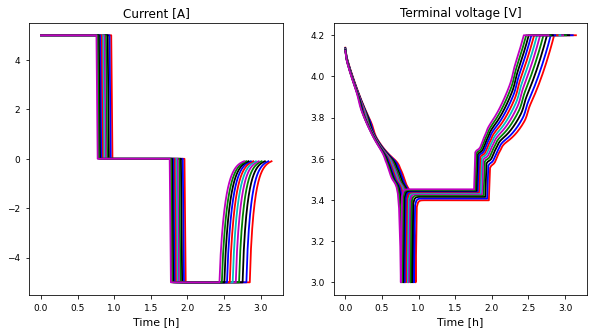

In [13]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
for cycle in sol_int.cycles:
    if cycle is not None:
        t = cycle["Time [h]"].data - cycle["Time [h]"].data[0]
        ax[0].plot(t, cycle["Current [A]"].data)
        ax[0].set_xlabel("Time [h]")
        ax[0].set_title("Current [A]")
        ax[1].plot(t, cycle["Terminal voltage [V]"].data)
        ax[1].set_xlabel("Time [h]")
        ax[1].set_title("Terminal voltage [V]")

All summary variables are always available for every cycle, since these are much less memory-intensive

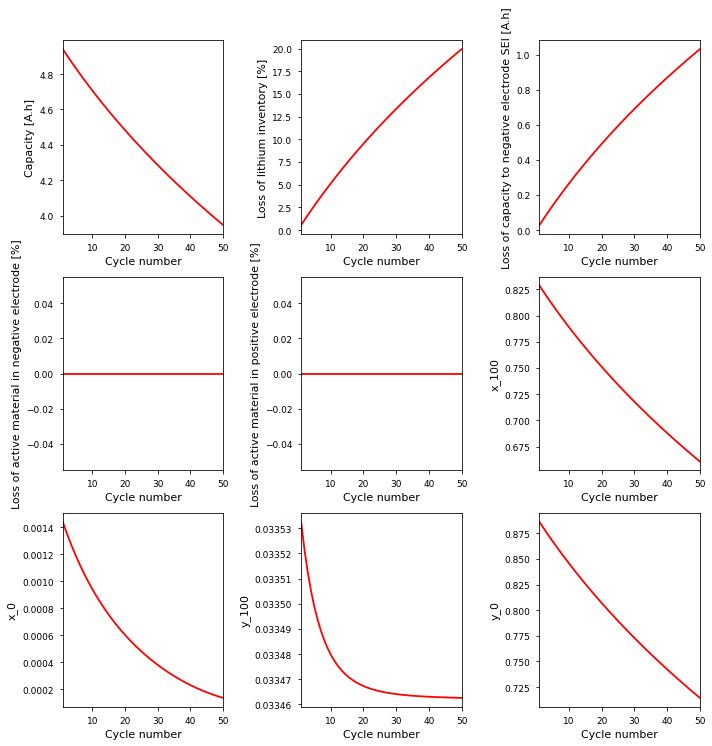

In [14]:
fig, axes = plt.subplots(n,m,figsize=(10,10))
for var, ax in zip(vars_to_plot,axes.flat):
    ax.plot(sol_list.summary_variables["Cycle number"], sol_list.summary_variables[var])
    ax.set_xlabel("Cycle number")
    ax.set_ylabel(var)
    ax.set_xlim([1,sol_list.summary_variables["Cycle number"][-1]])
fig.tight_layout()

## Starting solution

A simulation can be performed iteratively by using the `starting_solution` feature. For example, we first solve for 10 cycles

In [15]:
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
    f"Charge at 1C until {Vmax}V", 
    f"Hold at {Vmax}V until C/50")
] * 10,
termination="80% capacity"
)
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol = sim.solve()

2021-05-24 09:04:52,836 - [NOTICE] simulation.solve(710): Cycle 1/10 (50.983 ms elapsed) --------------------
2021-05-24 09:04:52,837 - [NOTICE] simulation.solve(742): Cycle 1/10, step 1/4: Discharge at 1C until 3.0V
2021-05-24 09:04:52,993 - [NOTICE] simulation.solve(742): Cycle 1/10, step 2/4: Rest for 1 hour
2021-05-24 09:04:53,172 - [NOTICE] simulation.solve(742): Cycle 1/10, step 3/4: Charge at 1C until 4.2V
2021-05-24 09:04:53,387 - [NOTICE] simulation.solve(742): Cycle 1/10, step 4/4: Hold at 4.2V until C/50
2021-05-24 09:04:53,911 - [NOTICE] simulation.solve(820): Capacity is now 4.941 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2021-05-24 09:04:53,912 - [NOTICE] simulation.solve(710): Cycle 2/10 (1.127 s elapsed) --------------------
2021-05-24 09:04:53,912 - [NOTICE] simulation.solve(742): Cycle 2/10, step 1/4: Discharge at 1C until 3.0V
2021-05-24 09:04:54,040 - [NOTICE] simulation.solve(742): Cycle 2/10, step 2/4: Rest for 1 hour
2021-05-24 09:04:54,136 - [NOTICE] simul

If we give `sol` as the starting solution this will then solve for the next 10 cycles

In [16]:
sol2 = sim.solve(starting_solution=sol)

2021-05-24 09:04:58,686 - [NOTICE] simulation.solve(710): Cycle 11/20 (75.591 ms elapsed) --------------------
2021-05-24 09:04:58,687 - [NOTICE] simulation.solve(742): Cycle 11/20, step 1/4: Discharge at 1C until 3.0V
2021-05-24 09:04:58,804 - [NOTICE] simulation.solve(742): Cycle 11/20, step 2/4: Rest for 1 hour
2021-05-24 09:04:58,907 - [NOTICE] simulation.solve(742): Cycle 11/20, step 3/4: Charge at 1C until 4.2V
2021-05-24 09:04:59,022 - [NOTICE] simulation.solve(742): Cycle 11/20, step 4/4: Hold at 4.2V until C/50
2021-05-24 09:04:59,385 - [NOTICE] simulation.solve(820): Capacity is now 4.684 Ah (originally 4.941 Ah, will stop at 3.952 Ah)
2021-05-24 09:04:59,386 - [NOTICE] simulation.solve(710): Cycle 12/20 (775.627 ms elapsed) --------------------
2021-05-24 09:04:59,387 - [NOTICE] simulation.solve(742): Cycle 12/20, step 1/4: Discharge at 1C until 3.0V
2021-05-24 09:04:59,505 - [NOTICE] simulation.solve(742): Cycle 12/20, step 2/4: Rest for 1 hour
2021-05-24 09:04:59,607 - [NO

We have now simulated 20 cycles

In [17]:
len(sol2.cycles)

20

## References

The relevant papers for this notebook are:

In [18]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[3] Scott G. Marquis, Valentin Sulzer, Robert Timms, Colin P. Please, and S. Jon Chapman. An asymptotic derivation of a single particle model with electrolyte. Journal of The Electrochemical Society, 166(15):A3693–A3706, 2019. doi:10.1149/2.0341915jes.
[4] Peyman Mohtat, Suhak Lee, Jason B Siegel, and Anna G Stefanopoulou. Towards better estimability of electrode-specific state of health: decoding the cell expansion. Journal of Power Sources, 427:101–111, 201